In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import shutil
import matplotlib.pyplot as plt

from torch.utils.tensorboard.writer import SummaryWriter
from tqdm import tqdm

from torch.amp.autocast_mode import autocast
from torch.amp.grad_scaler import GradScaler

In [55]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change this to your local path!
image_folder_path = r'C:\IIUM\AI Note IIUM\Deep_Learning\Task\Data'  # Or wherever your Pokémon live 🐉

images = []

# Walk through the folder and collect image paths
for root, dirs, files in os.walk(image_folder_path):
    for filename in files:
        if filename.lower().endswith(('jpg', 'jpeg', 'png')):
            images.append(os.path.join(root, filename))

# Shuffle for spicy data randomness
random.shuffle(images)

# Split into training and testing
split_point = int(0.8 * len(images))
image_train = images[:split_point]
image_test = images[split_point:]

print(f"Total images: {len(images)}")
print(f"Training: {len(image_train)}, Testing: {len(image_test)}")


Total images: 819
Training: 655, Testing: 164


In [56]:
transform1 = v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),

    ])
transform2 = v2.Compose([
    v2.Resize((56, 56)),
    ])


In [57]:
def load_image_hr(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        return transform1(img).to(device)
    except Exception as e:
        return None
def load_image_lr(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        im =  transform1(img).to(device)
        return transform2(im).to(device)
    except Exception as e:
        return None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


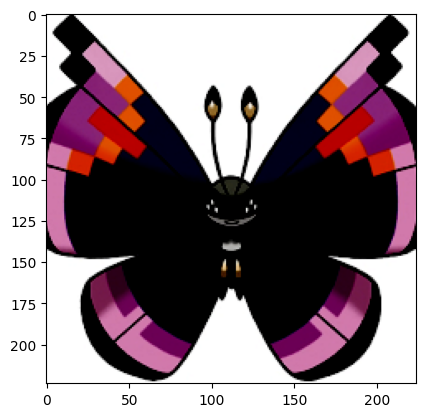

In [58]:
plt.imshow(load_image_hr(image_train[1]).permute(1, 2, 0).to('cpu')) # type: ignore

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7608686..1.0000001].


torch.Size([3, 56, 56])


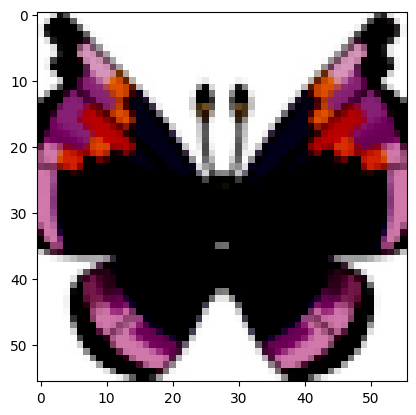

In [59]:
plt.imshow(load_image_lr(image_train[1]).permute(1, 2, 0).to('cpu'))
print(load_image_lr(image_train[1]).shape) # type: ignore

In [60]:
class Generator(nn.Module):
    def __init__(self, scale_factor=2):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.relu = nn.ReLU(inplace=True)
        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(16)])
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.upscale = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(scale_factor),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(scale_factor),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)
        self.ac = nn.Tanh()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        residual = x
        x = self.res_blocks(x)
        x = self.bn2(self.conv2(x))
        x += residual
        x = self.upscale(x)
        x = self.conv3(x)
        x = self.ac(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=1)
        )
        
    def forward(self, x):
        return self.model(x)





In [61]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [62]:
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=1e-5)
optimizer_D = torch.optim.RMSprop(generator.parameters(), lr=1e-5)


In [63]:

criterion_content = nn.L1Loss()

In [65]:
img1_train_hr = []
img1_train_lr = []
img1_test_lr = []

# Process training images
valid_train_indices = []
for i in range(len(image_train)):
    hr_img = load_image_hr(image_train[i])
    lr_img = load_image_lr(image_train[i])
    
    if hr_img is not None and lr_img is not None:
        img1_train_hr.append(hr_img.to(device))
        img1_train_lr.append(lr_img.to(device))
        valid_train_indices.append(i)

# Process test images
valid_test_indices = []
for i in range(len(image_test)):
    lr_img = load_image_lr(image_test[i])
    if lr_img is not None:
        img1_test_lr.append(lr_img.to(device))
        valid_test_indices.append(i)

print(f"Successfully loaded {len(img1_train_hr)} training images and {len(img1_test_lr)} test images")

# Only stack if we have valid images
if len(img1_train_hr) > 0 and len(img1_train_lr) > 0:
    img_train_hr = torch.stack(img1_train_hr).to('cpu')
    img_train_lr = torch.stack(img1_train_lr).to('cpu')

if len(img1_test_lr) > 0:
    img_test_lr = torch.stack(img1_test_lr).to('cpu')

Successfully loaded 98 training images and 0 test images


In [67]:
# --- Config ---
num_epochs = 5
batch_size = 64
n_critic = 3
clip_value = 0.02
sample_dir = "samples"
checkpoint_dir = "checkpoints"
writer = SummaryWriter("runs/superres_gan")  # tensorboard
os.makedirs(sample_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

# --- Mixed Precision Setup ---
scaler_G = GradScaler()
scaler_D = GradScaler()

def clip_weights(model, clip_value):
    for param in model.parameters():
        param.data.clamp_(-clip_value, clip_value)

# --- Training ---
global_step = 0
dataset_length = len(img_train_hr)
assert dataset_length == len(img_train_lr), "Mismatch between HR and LR dataset lengths!"

for epoch in range(num_epochs):
    print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
    order = torch.randperm(dataset_length)
    pbar = tqdm(range(0, dataset_length, batch_size), desc=f"Epoch {epoch+1}")

    for start_index in pbar:
        hr_imgs = img_train_hr[order[start_index:start_index+batch_size]].to(device)
        lr_imgs = img_train_lr[order[start_index:start_index+batch_size]].to(device)

        # === Train Discriminator ===
        for _ in range(n_critic):
            optimizer_D.zero_grad()
            with torch.cuda.amp.autocast():
                real_output = discriminator(hr_imgs)
                fake_imgs = generator(lr_imgs).detach()
                fake_output = discriminator(fake_imgs)

                d_loss = -torch.mean(real_output) + torch.mean(fake_output)

            scaler_D.scale(d_loss).backward()
            scaler_D.step(optimizer_D)
            scaler_D.update()
            clip_weights(discriminator, clip_value)

        # === Train Generator ===
        optimizer_G.zero_grad()
        with torch.cuda.amp.autocast():
            fake_imgs = generator(lr_imgs)
            fake_output = discriminator(fake_imgs)
            g_loss_adv = -torch.mean(fake_output)
            g_loss_content = criterion_content(fake_imgs, hr_imgs)
            g_loss = g_loss_adv + 1e-1 * g_loss_content

        scaler_G.scale(g_loss).backward()
        scaler_G.step(optimizer_G)
        scaler_G.update()

        # === Logging ===
        writer.add_scalar("Loss/Discriminator", d_loss.item(), global_step)
        writer.add_scalar("Loss/Generator_Total", g_loss.item(), global_step)
        writer.add_scalar("Loss/Generator_Content", g_loss_content.item(), global_step)
        global_step += 1

        pbar.set_postfix({
            "D Loss": f"{d_loss.item():.4f}",
            "G Loss": f"{g_loss.item():.4f}",
            "Content": f"{g_loss_content.item():.4f}"
        })

    # === Save Sample Image ===
    if epoch % 1 == 0:
        print("🖼️ Saving sample output...")
        with torch.no_grad():
            fake_sample = fake_imgs[1].detach().permute(1, 2, 0).to('cpu')
            real_sample = hr_imgs[1].detach().permute(1, 2, 0).to('cpu')
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(fake_sample)
        axes[0].set_title("Fake (Generated)")
        axes[1].imshow(real_sample)
        axes[1].set_title("Real (Ground Truth)")
        for ax in axes:
            ax.axis("off")
        plt.tight_layout()
        plt.savefig(f"{sample_dir}/epoch_{epoch:03}.png")
        plt.close()

    # === Save Checkpoints ===
    if epoch % 5 == 0 or epoch == num_epochs - 1:
        torch.save(generator.state_dict(), f"{checkpoint_dir}/generator_epoch{epoch:03}.pth")
        torch.save(discriminator.state_dict(), f"{checkpoint_dir}/discriminator_epoch{epoch:03}.pth")
        print("💾 Models saved.")




🚀 Epoch 1/5


Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s]C:\Users\KimieCrafter\AppData\Local\Temp\ipykernel_20916\1652235211.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.04 GiB is allocated by PyTorch, and 634.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

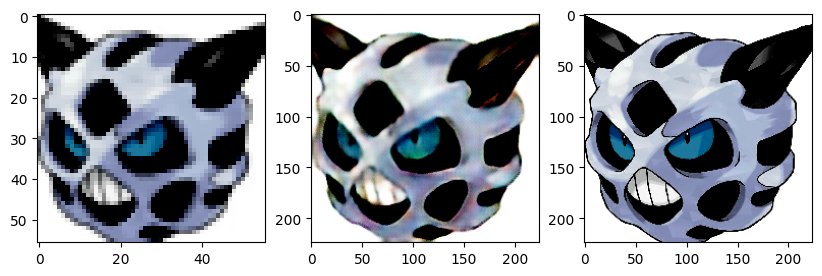

In [ ]:
hr_image = load_image_hr(image_test[14])
lr_image = load_image_lr(image_test[14])
generated = generator(lr_image.unsqueeze_(0))

fig, axes = plt.subplots(1, 3, figsize=(10, 5)) 
axes[0].imshow(lr_image[0].detach().permute(1, 2, 0).to('cpu'))
axes[1].imshow(generated[0].detach().permute(1, 2, 0).to('cpu'))
axes[2].imshow(hr_image.permute(1, 2, 0).to('cpu'))
plt.show()
torch.save(generator, 'generator.pth')
torch.save(discriminator, 'discriminator.pth')